In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [24]:
from fastai.conv_learner import *
from fastai.dataset import *
from fastai.models.resnet import vgg_resnet50

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models

import json, pdb
from PIL import ImageDraw, ImageFont, Image
from matplotlib import patches, patheffects


from MyUtils import LR_Scheduler

In [3]:
PATH = Path('data')
MASKS_FN = 'train_masks.csv'
META_FN = 'metadata.csv'
masks_csv = pd.read_csv(PATH/MASKS_FN)
meta_csv = pd.read_csv(PATH/META_FN)

In [49]:
def show_img(im, figsize=None, ax=None, alpha=None):
    if not ax: fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    return ax

In [5]:
TRAIN_DN = 'train'
MASKS_DN = 'train_masks'
sz = 128
bs = 64
nw = 16

In [6]:
x_names = np.array([Path(TRAIN_DN)/o for o in masks_csv['img']])
y_names = np.array([Path(MASKS_DN)/f'{o[:-4]}_mask.gif' for o in masks_csv['img']])

In [7]:
val_idxs = list(range(1008))
((val_x,trn_x),(val_y,trn_y)) = split_by_idx(val_idxs, x_names, y_names)

In [8]:
tr_tfms = transforms.Compose([
    transforms.RandomRotation(4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(sz),
    transforms.ToTensor()    
])
l_tfms = transforms.Compose([
    transforms.Resize((sz,sz)),
    transforms.ToTensor()
])

In [54]:
class custom_data(Dataset):
    def __init__(self, path, trn, label):
        super().__init__()
        self.path = path
        self.trn = trn
        self.label = label
        
    def __len__(self):
        return len(self.label)
    
    def __getitem__(self, index):
        img_name = self.path/self.trn[index]
        img = Image.open(img_name)
        img = tr_tfms(img)
        label = Image.open(self.path/self.label[index])
        label = l_tfms(label)
        label = label.squeeze()
        return img, label.float()
        

In [55]:
trn = custom_data(PATH, trn_x, trn_y)
val = custom_data(PATH, val_x, val_y)
trn = DataLoader(trn, batch_size=bs, shuffle=True)
val = DataLoader(val, batch_size=bs, shuffle=True)

In [33]:
x,y = next(iter(trn))

In [34]:
x.shape, y.shape

(torch.Size([64, 3, 128, 128]), torch.Size([64, 128, 128]))

In [13]:
f = resnet34

In [14]:
cut, lr_cut = model_meta[f]

In [15]:
def get_base():
    layers = cut_model(f(True), cut)
    return nn.Sequential(*layers)

In [16]:
def dice(pred, targs):
    pred = (pred>0).float()
    return 2. * (pred*targs).sum() / (pred+targs).sum()

In [17]:
class StdUpsample(nn.Module):
    def __init__(self, nin, nout):
        super().__init__()
        self.conv = nn.ConvTranspose2d(nin, nout, 2, stride=2)
        self.bn = nn.BatchNorm2d(nout)
    def forward(self, x): return self.bn(F.relu(self.conv(x)))

In [18]:
class Upsample34(nn.Module):
    def __init__(self, rn):
        super().__init__()
        self.rn = rn
        self.features = nn.Sequential(
        rn, nn.ReLU(),
        StdUpsample(512,256),
        StdUpsample(256,256),
        StdUpsample(256,256),
        StdUpsample(256,256),
        nn.ConvTranspose2d(256,1,2,stride=2)
        )
    def forward(self, x): return self.features(x)[:,0]

In [19]:
class UpsampleModel():
    def __init__(self, model, name='upsample'):
        self.model, self.name = model, name
    def get_layer_groups(self, precompute):
        lgs = list(split_by_idxs(children(self.model.rn), [lr_cut]))
        return lgs + [children(self.model.features)[1:]]

In [20]:
m_base = get_base()

In [21]:
m = to_gpu(Upsample34(m_base))

In [36]:
lr=4e-2
wd=1e-7
lrs = np.array([lr/100,lr/10,lr])/2

In [37]:
optimizer = optim.Adam(m.parameters(),lr)
Loss = nn.BCEWithLogitsLoss()

In [43]:
scheduler = MultiStepLR(optimizer, [2,4], gamma=0.1)

In [44]:
def train(data, model, epochs):
    for epoch in range(epochs):
        model.train()
        random.seed()
        tq = tqdm(total=len(data)*bs)
        tq.set_description(f'Epoch {epoch}, lr {lr}')
        losses = []
        scheduler.step()
        for i, (inputs, targets) in enumerate(data):
            inputs = Variable(inputs.cuda())
            targets = Variable(targets.cuda())
            outputs = model(inputs)
            loss = Loss(outputs, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            tq.update(bs)
            tq.set_postfix(loss=f'{loss}')
        tq.close()
        

In [45]:
train(trn, m, 4)


Epoch 3, lr 0.04: 100%|██████████| 4096/4096 [03:50<00:00, 18.97it/s, loss=0.005658220499753952] 


In [46]:
torch.save(m, 'unet.pkl')

/home/workmailofyi/anaconda3/envs/fastai_0.7/lib/python3.6/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type Upsample34. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/workmailofyi/anaconda3/envs/fastai_0.7/lib/python3.6/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type StdUpsample. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [56]:
x,y = next(iter(val))
py = to_np(m(V(x)))

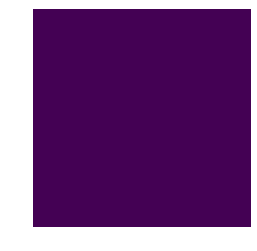

In [69]:
show_img(py[0]>0);

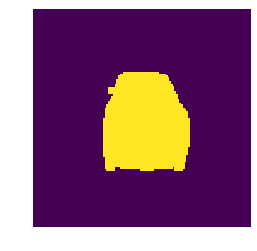

In [70]:
show_img(y[0]);

In [71]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

In [72]:
class UnetBlock(nn.Module):
    def __init__(self, up_in, x_in, n_out):
        super().__init__()
        up_out = x_out = n_out//2
        self.x_conv  = nn.Conv2d(x_in,  x_out,  1)
        self.tr_conv = nn.ConvTranspose2d(up_in, up_out, 2, stride=2)
        self.bn = nn.BatchNorm2d(n_out)
        
    def forward(self, up_p, x_p):
        up_p = self.tr_conv(up_p)
        x_p = self.x_conv(x_p)
        cat_p = torch.cat([up_p,x_p], dim=1)
        return self.bn(F.relu(cat_p))

In [73]:
class Unet34(nn.Module):
    def __init__(self, rn):
        super().__init__()
        self.rn = rn
        self.sfs = [SaveFeatures(rn[i]) for i in [2,4,5,6]]
        self.up1 = UnetBlock(512,256,256)
        self.up2 = UnetBlock(256,128,256)
        self.up3 = UnetBlock(256,64,256)
        self.up4 = UnetBlock(256,64,256)
        self.up5 = nn.ConvTranspose2d(256, 1, 2, stride=2)
        
    def forward(self,x):
        x = F.relu(self.rn(x))
        x = self.up1(x, self.sfs[3].features)
        x = self.up2(x, self.sfs[2].features)
        x = self.up3(x, self.sfs[1].features)
        x = self.up4(x, self.sfs[0].features)
        x = self.up5(x)
        return x[:,0]
    
    def close(self):
        for sf in self.sfs: sf.remove()

In [86]:
class UnetModel():
    def __init__(self,model,name='unet'):
        self.model,self.name = model,name

    def get_layer_groups(self, precompute):
        lgs = list(split_by_idxs(children(self.model.rn), [lr_cut]))
        return lgs + [children(self.model)[1:]]

In [87]:
m_base = get_base()
m = to_gpu(Unet34(m_base))
models = UnetModel(m)

In [76]:
lr=4e-2
wd=1e-7

lrs = np.array([lr/100,lr/10,lr])

In [88]:
optimizer = optim.Adam(m.parameters(),lr)
Loss = nn.BCEWithLogitsLoss()

In [ ]:
train(trn, m, 4)

In [90]:
x,y = next(iter(val))
py = to_np(m(V(x)))

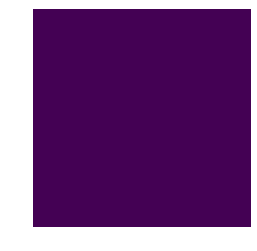

In [91]:
show_img(py[0]>0);

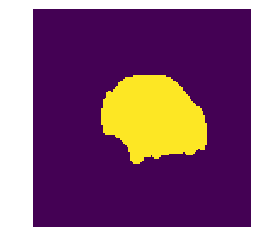

In [92]:
show_img(y[0]);

In [93]:
ex = torch.randn((8,3,128,128))

In [ ]:
py = to_np(models(V(ex)))

In [121]:
sfs = SaveFeatures(children(m)[0])

In [122]:
print(sfs.features)

None
